In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
# output some informations concerning the types of the variables in the dataframe 
# and the quantity of null values for each variable
df = pd.read_csv("C:/Users/wxp/Downloads/flight-delays/flight_short.csv", low_memory=False)
print('Dataframe dimensions:', df.shape)
#____________________________________________________________
# gives some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info

Dataframe dimensions: (469968, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,2782,0,0,0,11657,11657,11876,11876,0,12955,12955,0,12271,12271,0,12271,12955,0,0,457986,374017,374017,374017,374017,374017
null values (%),0,0,0,0,0,0,0.591955,0,0,0,2.48038,2.48038,2.52698,2.52698,0,2.75657,2.75657,0,2.61103,2.61103,0,2.61103,2.75657,0,0,97.4505,79.5835,79.5835,79.5835,79.5835,79.5835


In [ ]:
#  plot the airports location and indicate the number of flights recorded 
count_flights = df['ORIGIN_AIRPORT'].value_counts()
#___________________________
plt.figure(figsize=(11,11))
#________________________________________
# define properties of markers and labels
colors = ['yellow', 'red', 'lightblue', 'purple', 'green', 'orange']
size_limits = [1, 100, 1000, 10000, 100000, 1000000]
labels = []
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1])) 
#____________________________________________________________
map = Basemap(resolution='i',llcrnrlon=-180, urcrnrlon=-50,
              llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0,)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='0.3')
#_____________________
# put airports on map
for index, (code, y,x) in airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
    x, y = map(x, y)
    isize = [i for i, val in enumerate(size_limits) if val < count_flights[code]]
    ind = isize[-1]
    map.plot(x, y, marker='o', markersize = ind+5, markeredgewidth = 1, color = colors[ind],
             markeredgecolor='k', label = labels[ind])
#_____________________________________________
# remove duplicate labels and set their order
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 <.< 100', '100 <.< 1000', '1000 <.< 10000',
             '10000 <.< 100000', '100000 <.< 1000000')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]
plt.legend(new_label.values(), new_label.keys(), loc = 1, prop= {'size':11},
           title='Number of flights per year', frameon = True, framealpha = 1)
plt.show()

In [6]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

In [7]:
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
#_____________________________________________________________________
# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
#_______________________________________________________________________________
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

In [8]:
# modify the dataframe variables
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_heure)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_heure)
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2015-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2015-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2015-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2015-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2015-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


In [9]:
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235,215.0


In [10]:
# examine how complete the dataset is
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,ARRIVAL_DELAY,12955,97.243429
1,ELAPSED_TIME,12955,97.243429
2,ARRIVAL_TIME,12271,97.388971
3,DEPARTURE_TIME,11657,97.519618
4,DEPARTURE_DELAY,11657,97.519618
5,AIRLINE,0,100.000000
6,ORIGIN_AIRPORT,0,100.000000
7,DESTINATION_AIRPORT,0,100.000000
8,SCHEDULED_DEPARTURE,0,100.000000
9,SCHEDULED_ARRIVAL,0,100.000000


In [11]:
# simply remove the entries that contain missing values
df.dropna(inplace = True)

In [2]:
airlines_names = pd.read_csv("C:/Users/wxp/Downloads/flight-delays/airlines.csv")
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [3]:
# keep as dictionary
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()
abbr_companies

{'AA': 'American Airlines Inc.',
 'AS': 'Alaska Airlines Inc.',
 'B6': 'JetBlue Airways',
 'DL': 'Delta Air Lines Inc.',
 'EV': 'Atlantic Southeast Airlines',
 'F9': 'Frontier Airlines Inc.',
 'HA': 'Hawaiian Airlines Inc.',
 'MQ': 'American Eagle Airlines Inc.',
 'NK': 'Spirit Air Lines',
 'OO': 'Skywest Airlines Inc.',
 'UA': 'United Air Lines Inc.',
 'US': 'US Airways Inc.',
 'VX': 'Virgin America',
 'WN': 'Southwest Airlines Co.'}

In [83]:
# function that extract statistical parameters from a grouby objet:
# to deal with data, we could group it.
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
#global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
#global_stats = global_stats.sort_values('count')
#global_stats

In [97]:
stat_arrival = df['ARRIVAL_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack().sort_values('count')
stat_arrival = stat_arrival.sort_values('count')
stat_arrival

,count,max,mean,min
AIRLINE,,,,
VX,4647.0,384.0,1.420702,-70.0
HA,6408.0,1013.0,3.512640,-52.0
F9,6735.0,686.0,18.357238,-47.0
NK,8632.0,570.0,11.398054,-59.0
AS,13151.0,451.0,-0.320888,-82.0
B6,20482.0,502.0,7.347281,-76.0
MQ,27568.0,788.0,18.164974,-60.0
US,32478.0,621.0,3.107457,-67.0
UA,37363.0,863.0,6.352729,-69.0


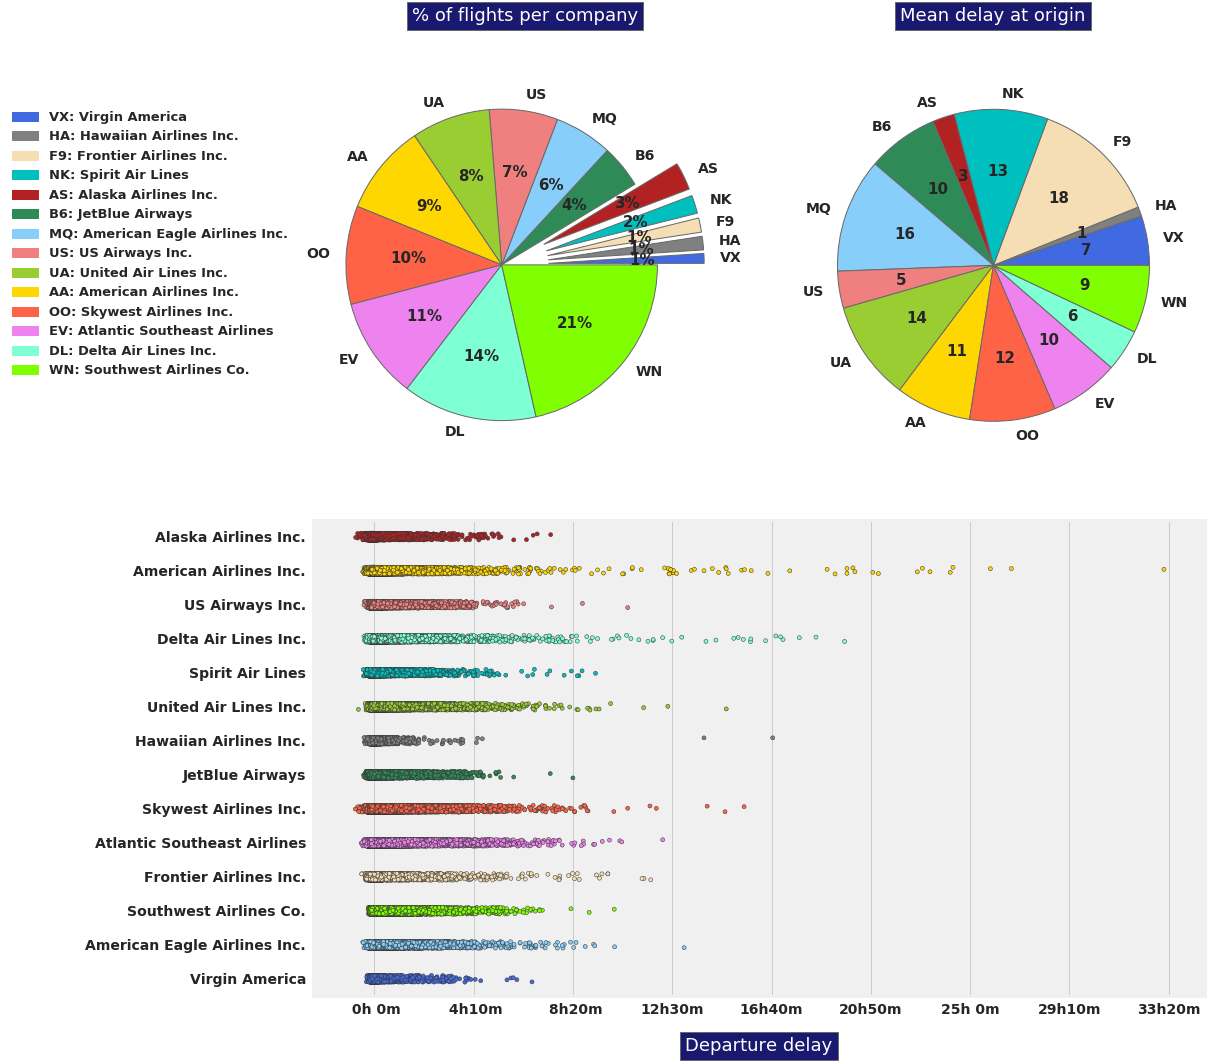

In [48]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3) 

In [15]:
# Relation between the origin airport and delays
print("Nb of airports: {}".format(len(df['ORIGIN_AIRPORT'].unique())))

Nb of airports: 312


In [16]:
origin_nb = dict()
for carrier in abbr_companies.keys():
    liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    origin_nb[carrier] = len(liste_origin_airport)
origin_nb

{'AA': 81,
 'AS': 59,
 'B6': 57,
 'DL': 145,
 'EV': 166,
 'F9': 63,
 'HA': 17,
 'MQ': 122,
 'NK': 33,
 'OO': 175,
 'UA': 77,
 'US': 74,
 'VX': 18,
 'WN': 86}

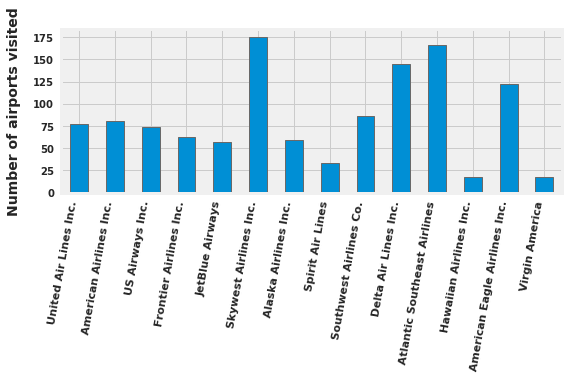

In [52]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

In [41]:
# start doing some analysis by myself
wxp = pd.read_csv("C:/Users/wxp/Desktop/R_flight.csv",low_memory = False)
wxp = wxp[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]

In [5]:
wxp[wxp['ORIGIN_AIRPORT'] == 'LAX']

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
1,AA,LAX,PBI,1/1/2015 0:10,0:02:00,-8,7:50:00,7:41:00,-9,280,279
3,AA,LAX,MIA,1/1/2015 0:20,0:15:00,-5,8:05:00,7:56:00,-9,285,281
7,US,LAX,CLT,1/1/2015 0:30,0:44:00,14,8:03:00,7:53:00,-10,273,249
12,DL,LAX,MSP,1/1/2015 0:35,0:35:00,0,6:09:00,6:05:00,-4,214,210
23,AA,LAX,MIA,1/1/2015 1:05,1:03:00,-2,8:51:00,8:39:00,-12,286,276
25,UA,LAX,IAH,1/1/2015 1:15,1:12:00,-3,6:18:00,6:07:00,-11,183,175
129,UA,LAX,DEN,1/1/2015 5:50,5:50:00,0,9:15:00,9:06:00,-9,145,136
135,AA,LAX,DFW,1/1/2015 5:50,6:00:00,10,10:50:00,10:52:00,2,180,172
160,UA,LAX,IAH,1/1/2015 5:57,5:55:00,-2,11:09:00,10:53:00,-16,192,178
190,UA,LAX,ORD,1/1/2015 6:00,6:07:00,7,12:10:00,11:54:00,-16,250,227


In [5]:
airports_names = pd.read_csv("C:/Users/wxp/Downloads/flight-delays/airports.csv")
abbr_locations = airports_names.set_index('IATA_CODE')['AIRPORT'].to_dict()
abbr_locations
origin_nb = dict()
for carrier in abbr_locations.keys():
    liste_origin_airport = wxp[wxp['ORIGIN_AIRPORT'] == carrier]['AIRLINE'].unique()
    origin_nb[carrier] = len(liste_origin_airport)
type(origin_nb)

dict

In [83]:
airline_numbers = pd.DataFrame.from_dict(origin_nb, orient='index')
airline_numbers.rename(columns = {0:'count'}, inplace = True)
airline_numbers.plot(kind = 'bar')

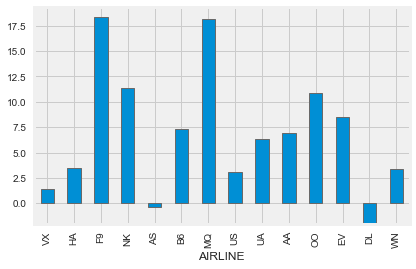

In [98]:
# series type use this way
stat_arrival['mean'].plot(kind = 'bar')
global_stats['mean'].plot(kind = 'barh')

In [119]:
# change series to dataframe type
a = pd.DataFrame.from_dict(stat_arrival['mean'])
a.rename(columns = {'mean':'arrive'}, inplace = True)
b = pd.DataFrame.from_dict(global_stats['mean'])
b.rename(columns = {'mean':'departure'}, inplace = True)

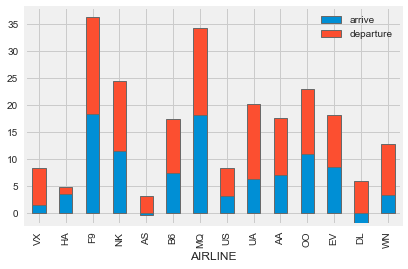

In [122]:
pd.concat([a, b], axis=1, join='inner').plot.bar(stacked=True)

In [123]:
dddf = pd.read_csv("C:/Users/wxp/Downloads/flight-delays/flights.csv", low_memory=False)
a = []
for i in range(1,13):
    a.append(len(dddf[dddf['MONTH']==i]))
plt.plot(pd.DataFrame(a))
plt.xticks(np.arange(1, 13, 1.0))
plt.show()

In [5]:
collect_arrival = []
for carrier in abbr_companies.keys():
    collect_arrival.append(wxp[wxp['AIRLINE'] == carrier]['ARRIVAL_DELAY'])

In [6]:
a = wxp[wxp['AIRLINE'] == 'AA']['ARRIVAL_DELAY']
a = pd.DataFrame(a)
a.rename(columns = {'ARRIVAL_DELAY':'AA_DELAY'}, inplace = True)

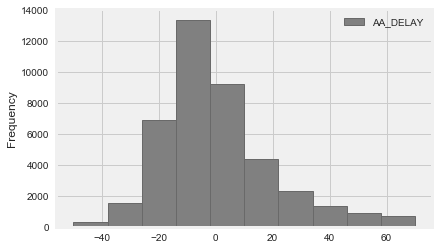

In [7]:
a.plot.hist(30, range=[-50,70], facecolor='gray', align='mid')

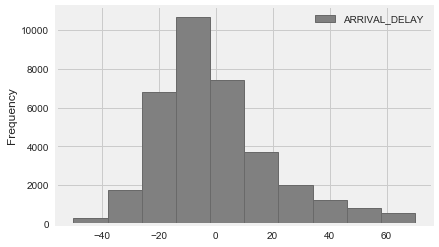

In [8]:
pd.DataFrame(collect_arrival[0]).plot.hist(30, range=[-50,70], facecolor='gray', align='mid')

In [9]:
a = a.reset_index()
del a['index']
b = a.sort(columns='AA_DELAY', axis=0, ascending=True, inplace=False)
b = b.reset_index()
del b['index']

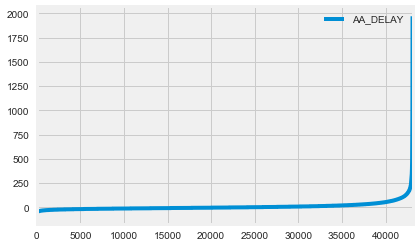

In [11]:
b.plot()

In [23]:
airport_mean_delays = pd.DataFrame(pd.Series(wxp['ORIGIN_AIRPORT'].unique()))
# delete the series number
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    df1 = wxp[wxp['AIRLINE'] == carrier]
    test = df1['ARRIVAL_DELAY'].groupby(wxp['ORIGIN_AIRPORT']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 

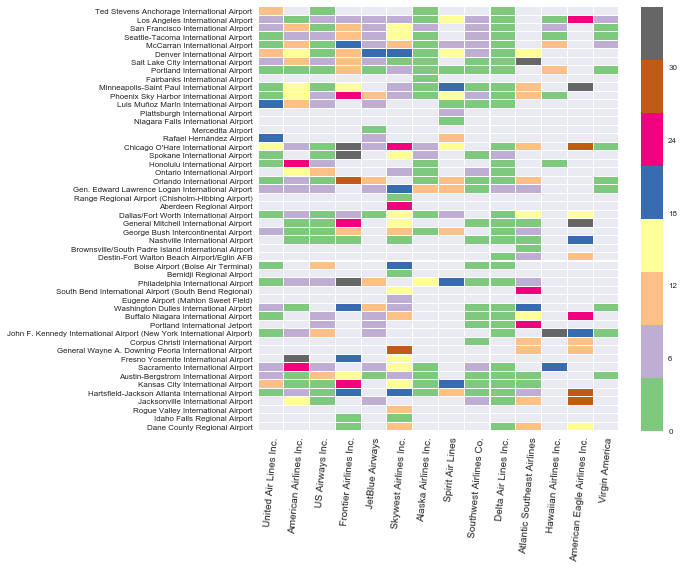

In [33]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(16,8))
ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = abbr_locations)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)
plt.tight_layout()

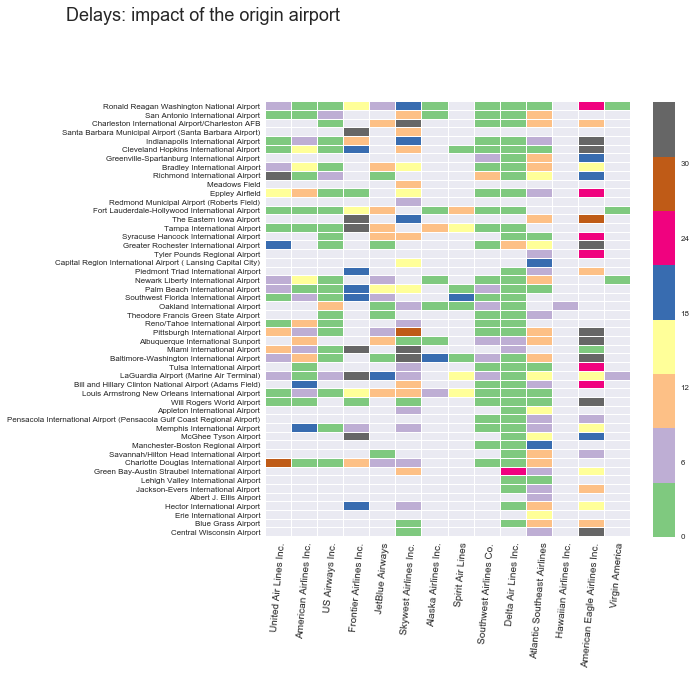

In [38]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(16,8))
ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = abbr_locations)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

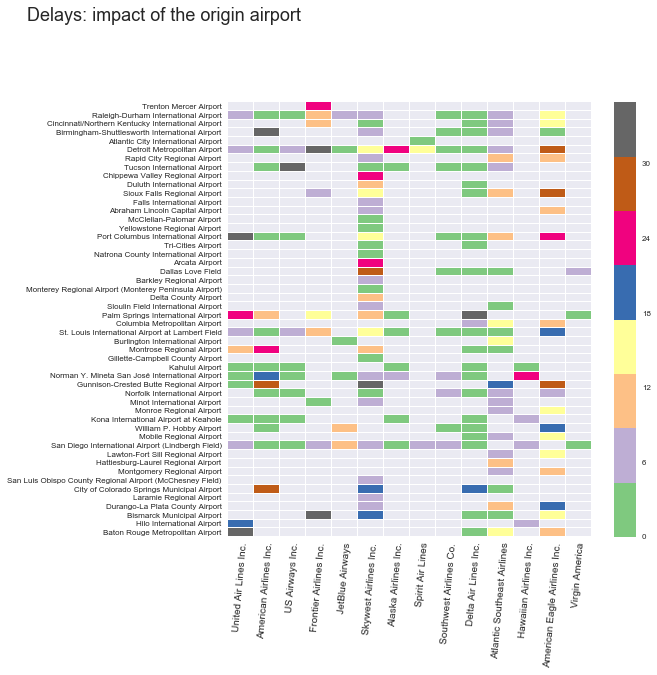

In [41]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(16,8))
ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[100:150,:].rename(columns = abbr_companies)
subset = subset.rename(index = abbr_locations)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

In [6]:
# collect the rought and its delay into a dict
carrier = 'AA'
wxp1 = wxp[wxp['AIRLINE']==carrier][['ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]
trajet = dict()
for ind, col in wxp1.iterrows():
    if pd.isnull(col['DEPARTURE_DELAY']): continue
    route = str(col['ORIGIN_AIRPORT'])+'-'+str(col['DESTINATION_AIRPORT'])
    if route in trajet.keys():
        trajet[route].append(col['DEPARTURE_DELAY'])
    else:
        trajet[route] = [col['DEPARTURE_DELAY']]

In [7]:
# convert dict to a list 
liste_trajet = []
for key, value in trajet.items():
    liste_trajet.append([key, value])
liste_trajet.sort()


In [8]:
a = []
for carrier in trajet.keys():
    a.append(sum(trajet[carrier])/len(trajet[carrier]))

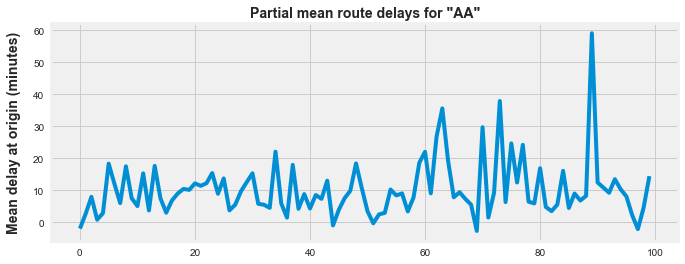

In [9]:
fig, ax = plt.subplots(figsize=(10,4))
plt.plot(a[:100])
plt.ylabel('Mean delay at origin (minutes)', fontsize=14, weight = 'bold', labelpad=12)
ax.set_title('Partial mean route delays for "AA"',fontsize=14, weight = 'bold')
plt.show()

In [29]:
list(trajet.keys())[0]

'LAX-PBI'

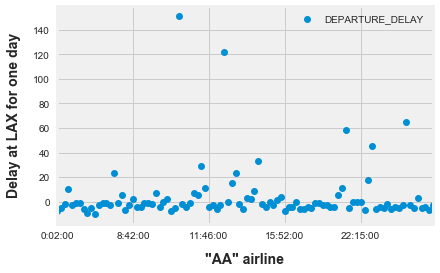

In [30]:
a = wxp[wxp['ORIGIN_AIRPORT'] == 'LAX']
b = a[a['AIRLINE'] == 'AA']
b[:100].plot(x='DEPARTURE_TIME', y='DEPARTURE_DELAY', style='o')
plt.xlabel('"AA" airline', fontsize=14, weight = 'bold', labelpad=12)
plt.ylabel('Delay at LAX for one day', fontsize=14, weight = 'bold', labelpad=12)
plt.show()

In [65]:
# Delete outliers
Series_LAX = b['ARRIVAL_DELAY']
mean = Series_LAX.mean()
sd = Series_LAX.std()
final_list = [x for x in Series_LAX if (x > mean - 2 * sd)]
final_list = [x for x in final_list if (x < mean + 2 * sd)]

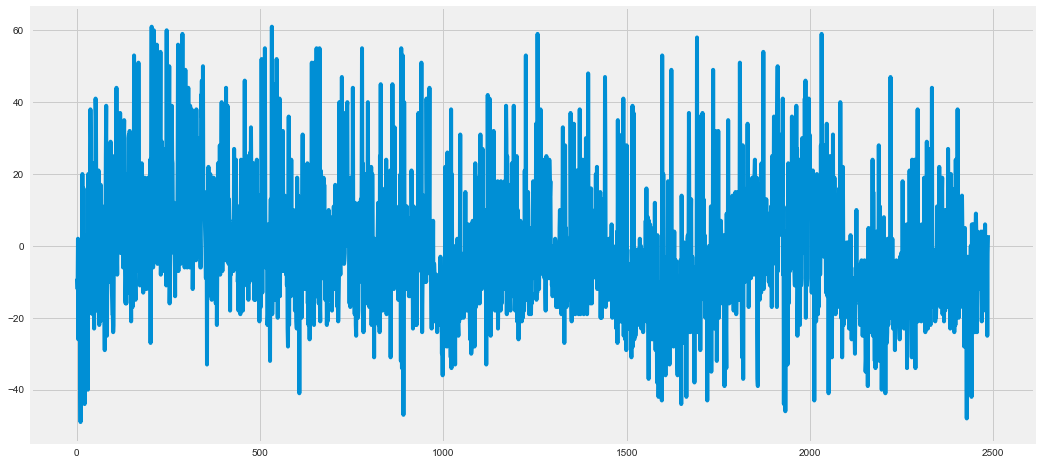

In [146]:
fig = plt.figure(1, figsize=(16,8))
plt.plot(final_list)

In [76]:
b

,index,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,1,AA,LAX,PBI,1/1/2015,0:02:00,-8,7:50:00,7:41:00,-9,280,279
1,3,AA,LAX,MIA,1/1/2015,0:15:00,-5,8:05:00,7:56:00,-9,285,281
2,23,AA,LAX,MIA,1/1/2015,1:03:00,-2,8:51:00,8:39:00,-12,286,276
3,135,AA,LAX,DFW,1/2/2015,6:00:00,10,10:50:00,10:52:00,2,180,172
4,211,AA,LAX,ORD,1/3/2015,5:57:00,-3,12:05:00,11:39:00,-26,245,222
5,394,AA,LAX,STL,1/5/2015,6:09:00,-1,11:45:00,11:34:00,-11,215,205
6,478,AA,LAX,DFW,1/6/2015,6:19:00,-1,11:20:00,11:19:00,-1,180,180
7,695,AA,LAX,SFO,1/8/2015,6:44:00,-6,8:10:00,8:03:00,-7,80,79
8,701,AA,LAX,DFW,1/8/2015,6:41:00,-9,11:50:00,11:49:00,-1,180,188
9,733,AA,LAX,BOS,1/9/2015,6:50:00,-5,15:15:00,14:42:00,-33,320,292


In [57]:
# change the schedule time, leave the day,month,year only
b = b.reset_index()
del b['index']
bb = list(b['SCHEDULED_DEPARTURE'])
for i in range(2585):
    bb[i] = bb[i][:9]
aa = pd.Series(bb)
b['SCHEDULED_DEPARTURE'] = aa

In [82]:
b

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AA,LAX,PBI,1/1/2015,0:02:00,-8,7:50:00,7:41:00,-9,280,279
1,AA,LAX,MIA,1/1/2015,0:15:00,-5,8:05:00,7:56:00,-9,285,281
2,AA,LAX,MIA,1/1/2015,1:03:00,-2,8:51:00,8:39:00,-12,286,276
3,AA,LAX,DFW,1/1/2015,6:00:00,10,10:50:00,10:52:00,2,180,172
4,AA,LAX,ORD,1/1/2015,5:57:00,-3,12:05:00,11:39:00,-26,245,222
5,AA,LAX,STL,1/1/2015,6:09:00,-1,11:45:00,11:34:00,-11,215,205
6,AA,LAX,DFW,1/1/2015,6:19:00,-1,11:20:00,11:19:00,-1,180,180
7,AA,LAX,SFO,1/1/2015,6:44:00,-6,8:10:00,8:03:00,-7,80,79
8,AA,LAX,DFW,1/1/2015,6:41:00,-9,11:50:00,11:49:00,-1,180,188
9,AA,LAX,BOS,1/1/2015,6:50:00,-5,15:15:00,14:42:00,-33,320,292


In [86]:
# get the mean for every day, sort data by date
Daily_delay = b['ARRIVAL_DELAY'].groupby(b['SCHEDULED_DEPARTURE']).apply(get_stats).unstack()
aaa = Daily_delay.reset_index()
aaa['SCHEDULED_DEPARTURE'] =pd.to_datetime(aaa.SCHEDULED_DEPARTURE)
Daily_delay = aaa.sort('SCHEDULED_DEPARTURE')

In [101]:
Daily_delay

,SCHEDULED_DEPARTURE,count,max,mean,min
0,2015-01-01,88.0,147.0,0.443182,-49.0
11,2015-01-02,94.0,209.0,12.404255,-24.0
22,2015-01-03,88.0,156.0,18.715909,-27.0
25,2015-01-04,95.0,210.0,25.642105,-14.0
26,2015-01-05,97.0,173.0,16.505155,-33.0
27,2015-01-06,81.0,258.0,7.209877,-21.0
28,2015-01-07,83.0,111.0,6.650602,-32.0
29,2015-01-08,87.0,146.0,5.540230,-41.0
30,2015-01-09,85.0,236.0,13.600000,-22.0
1,2015-01-10,77.0,55.0,-0.545455,-31.0


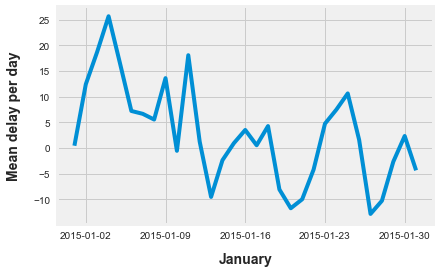

In [108]:
fig = plt.figure()  # create a figure object
ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
ax.plot(Daily_delay['SCHEDULED_DEPARTURE'],Daily_delay['mean'])
ax.set_ylabel('some numbers')
plt.xlabel('January', fontsize=14, weight = 'bold', labelpad=12)
plt.ylabel('Mean delay per day', fontsize=14, weight = 'bold', labelpad=12)

In [2]:
# Logistic Regression, input the data first
lr = pd.read_csv("C:/Users/wxp/Downloads/flight-delays/flight_short.csv", low_memory=False)
lr = lr[['DAY_OF_WEEK','AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
a = lr[lr['AIRLINE'] == 'AA']
a = a.reset_index()
del a['index']
Series_A = a['DEPARTURE_DELAY']
Series_A = [1 if x>0 else x for x in Series_A]
Series_A = [0 if x<0 else x for x in Series_A]
a['DEPARTURE_DELAY'] = Series_A 

In [3]:
# remove missing entries
a.dropna(inplace = True)
missing_df = a.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(a.shape[0]-missing_df['missing values'])/a.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,DAY_OF_WEEK,0,100.0
1,AIRLINE,0,100.0
2,ORIGIN_AIRPORT,0,100.0
3,DESTINATION_AIRPORT,0,100.0
4,SCHEDULED_DEPARTURE,0,100.0
5,DEPARTURE_DELAY,0,100.0
6,SCHEDULED_TIME,0,100.0
7,ELAPSED_TIME,0,100.0


In [4]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report

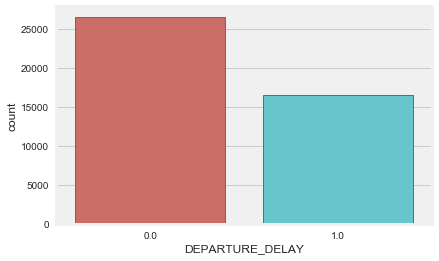

In [5]:
sb.countplot(x='DEPARTURE_DELAY',data=a, palette='hls')

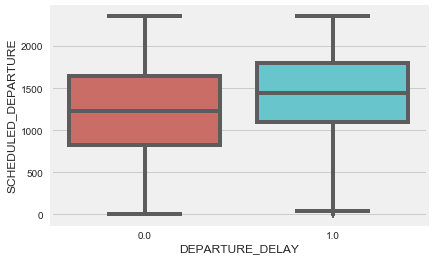

In [55]:
# let's see how scheduled deparure time impact departure delay
sb.boxplot(x='DEPARTURE_DELAY', y='SCHEDULED_DEPARTURE', data=a, palette='hls')
# speaking roughly, morning is not easy to late.

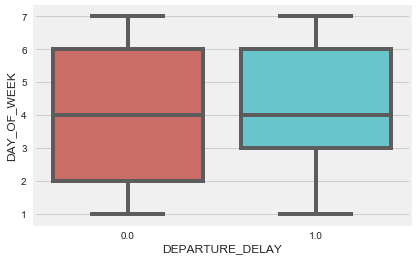

In [57]:
sb.boxplot(x='DEPARTURE_DELAY', y='DAY_OF_WEEK', data=a, palette='hls')
# Wednesday seems to easily get late.

In [6]:
# transform the location variable to data.
air_location = pd.get_dummies(a['ORIGIN_AIRPORT'],drop_first=True)
#air_location.head()

In [7]:
a.drop(['AIRLINE', 'ORIGIN_AIRPORT','DESTINATION_AIRPORT','ELAPSED_TIME'],axis=1,inplace=True)
a = a[['DEPARTURE_DELAY', 'DAY_OF_WEEK', 'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME']]
delay_lr = pd.concat([a,air_location],axis=1)
delay_lr.head()

,DAY_OF_WEEK,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,SCHEDULED_TIME,ATL,AUS,BDL,BHM,BNA,BOS,BWI,CLE,CLT,CMH,COS,DAY,DCA,DEN,DFW,DSM,DTW,EGE,ELP,EWR,FAT,...,PDX,PHL,PHX,PIT,PSP,RDU,RIC,RNO,RSW,SAN,SAT,SDF,SEA,SFO,SJC,SJU,SLC,SMF,SNA,STL,STT,STX,TPA,TUL,TUS
0,4,10,0.0,280,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,20,0.0,285,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,30,0.0,195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,4,35,0.0,268,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,100,0.0,338,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


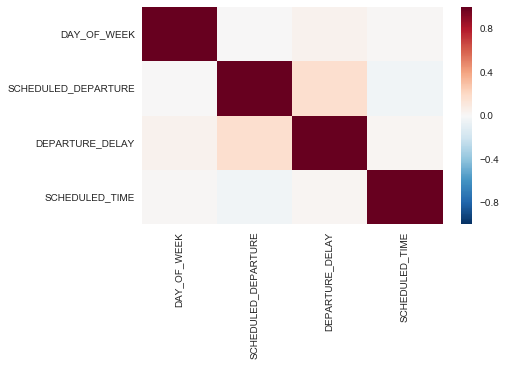

In [8]:
# correlation
sb.heatmap(a.corr())
# seems to be independent between each varialbe

In [46]:
#delay_lr.info()
X = delay_lr.ix[:,1:83].values
y = delay_lr.ix[:,0].values

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

In [48]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [49]:
y_pred = LogReg.predict(X_test)

In [50]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[6875, 1079],
       [3743, 1226]])

In [51]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.65      0.86      0.74      7954
        1.0       0.53      0.25      0.34      4969

avg / total       0.60      0.63      0.59     12923



In [53]:
print(metrics.accuracy_score(y_test, y_pred))

0.626866826588
